In [126]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import matplotlib
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from carbonplan_forest_risks import load, setup, plot, fit, utils, prepare, collect
from carbonplan.data import cat
from carbonplan_styles.mpl import get_colormap

from showit import image

In [127]:
coarsen = 4

In [128]:
def load_bill(url):
    target = cat.nlcd.raster.to_dask()
    source = xr.open_rasterio(url)
    source = source.where(source > -1)
    ds = source.rio.reproject_match(target, resampling=Resampling.bilinear)
    ds = (
        ds.where(ds > -1)
        .coarsen(x=coarsen, y=coarsen, boundary="trim")
        .mean()
        .sel(band=1)
    )

    return ds

In [129]:
dataset_urls = {
    "insects": {
        "AUC": "SuppFig_InsectModel_CV_AUC_04-22-2021.tif",
        "R2": "SuppFig_InsectModel_CV_nonzeroR2_04-22-2021.tif",
    },
    "drought": {
        "AUC": "SuppFig_DroughtModel_CV_AUC_04-22-2021.tif",
        "R2": "SuppFig_DroughtModel_CV_nonzeroR2_04-22-2021.tif",
    },
}

In [130]:
ds_dict = {}
ds_dict['insects'] = {}
ds_dict['drought'] = {}
ds_dict['insects']['AUC'] = load_bill(dataset_urls['insects']['AUC'])
ds_dict['insects']['R2'] = load_bill(dataset_urls['insects']['R2'])
ds_dict['drought']['AUC'] = load_bill(dataset_urls['drought']['AUC'])
ds_dict['drought']['R2'] = load_bill(dataset_urls['drought']['R2'])

/srv/conda/envs/notebook/lib/python3.8/site-packages/rioxarray/raster_array.py:126: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/rioxarray/raster_array.py:126: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/rioxarray/raster_array.py:126: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/rioxarray/raster_array.py:126: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(


In [131]:
plot_params = {
    "drought_AUC": {
        "cmap": get_colormap("pinks"),
        "var_lims": (0.5, 0.8),
        "label": "Drought-related\nmortality (%/year)",
        "panel": ["C", "D"],
        "cbar_ylocation": 0.15,
        "cbar_xlocation": 0.46,
    },
    "insects_AUC": {
        "cmap": get_colormap("blues"),
        "var_lims": (0.5, 0.8),
        "label": "Insect-related\nmortality (%/year)",
        "panel": ["E", "F"],
        "cbar_ylocation": 0.64,
        "cbar_xlocation": 0.46,
    },
     "drought_R2": {
        "cmap": get_colormap("pinks"),
         "var_lims": (0, 0.05),
        "label": "Drought-related\nmortality (%/year)",
        "panel": ["C", "D"],
        "cbar_ylocation": 0.15,
        "cbar_xlocation": 1.01,
    },
    "insects_R2": {
        "cmap": get_colormap("blues"),
        "var_lims": (0, 0.15),
        "label": "Insect-related\nmortality (%/year)",
        "panel": ["E", "F"],
        "cbar_ylocation": 0.64,
        "cbar_xlocation": 1.01,
    },
}

In [132]:
matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Helvetica Neue")
matplotlib.rc("text", usetex="false")
matplotlib.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

<ipython-input-133-2176d40a5914>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=-6)


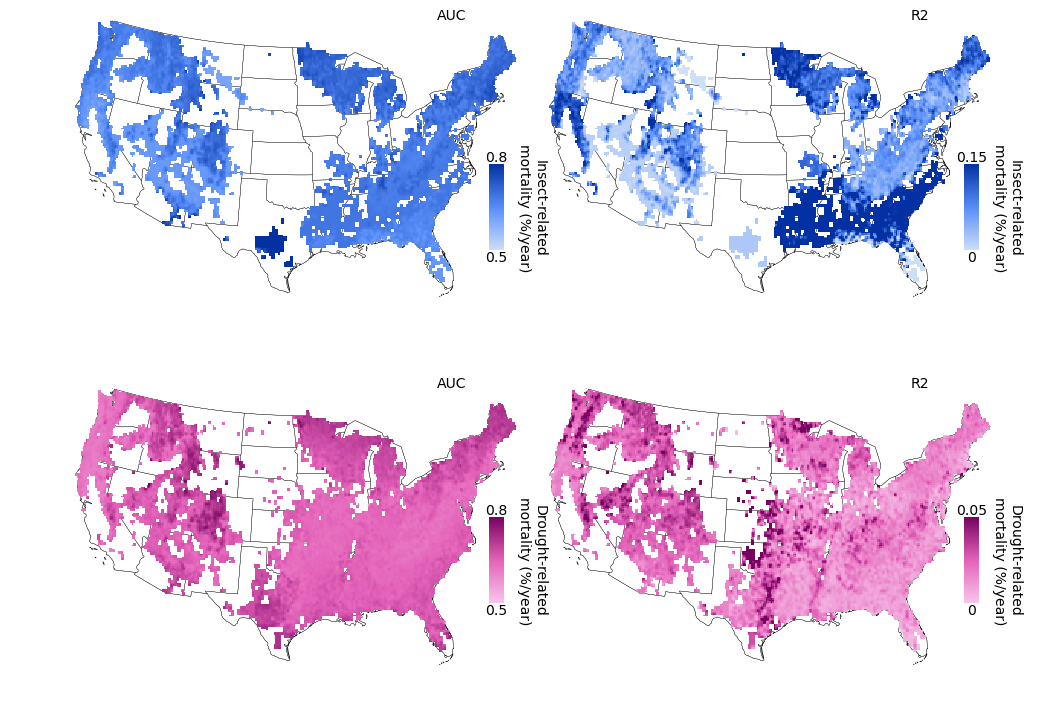

In [133]:
fig, axarr = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 10),
    subplot_kw={"projection": plot.cartopy_proj_albers()},
)
for row, dataset in enumerate(["insects", "drought"]):
    for column, metric in enumerate(["AUC", "R2"]):
        vmin, vmax = (
            plot_params['{}_{}'.format(dataset, metric)]["var_lims"][0],
            plot_params['{}_{}'.format(dataset, metric)]["var_lims"][1],
        )
        map_plot = ds_dict[dataset][metric].plot.imshow(
            ax=axarr[row, column],
            cmap=plot_params['{}_{}'.format(dataset, metric)]["cmap"],
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
            add_labels=False
        )
        plot.map_pretty(axarr[row, column], title=metric)
        plot.add_colorbar(
            fig,
            to_plot=map_plot,
            y_location=plot_params['{}_{}'.format(dataset, metric)]["cbar_ylocation"],
            x_location=plot_params['{}_{}'.format(dataset, metric)]["cbar_xlocation"],
            vmin=plot_params['{}_{}'.format(dataset, metric)]["var_lims"][0],
            vmax=plot_params['{}_{}'.format(dataset, metric)]["var_lims"][1],
            cbar_label=plot_params['{}_{}'.format(dataset, metric)]["label"],
        )
plt.tight_layout(pad=-6)
fig.savefig("Supplementary-Figure-4.svg", format="svg", bbox_inches="tight")

In [134]:
df_drought = pd.read_csv('Drought_USwide_CrossValidationR2_4-21-21.csv', header=None)
df_insects = pd.read_csv('Insect_USwide_CrossValidationR2_4-21-21.csv', header=None)

In [135]:
print('drought: spatial cross validation R2 percentiles')
print(np.percentile(df_drought[0], [5, 50, 95]))

drought: spatial cross validation R2 percentiles
[0.16094525 0.1818061  0.19855712]


In [136]:
print('insects: spatial cross validation R2 percentiles')
print(np.percentile(df_insects[0], [5, 50, 95]))

insects: spatial cross validation R2 percentiles
[0.27359194 0.3060119  0.33789432]
